# Eigenes Modell

## Imports

In [39]:
import pathlib
import PIL.Image
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import glob
import random
import splitfolders
import os, shutil

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from datetime import datetime

In [40]:
print('Num GPUs Available: ', len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


## Read Image Data

In [41]:
#Set data directory
data_dir = pathlib.Path('./data')

In [42]:
#show number of images included in directory
image_count = len(list(data_dir.glob('*/*.jpg')))
print('# of Images found: ' + str(image_count))

# of Images found: 2527


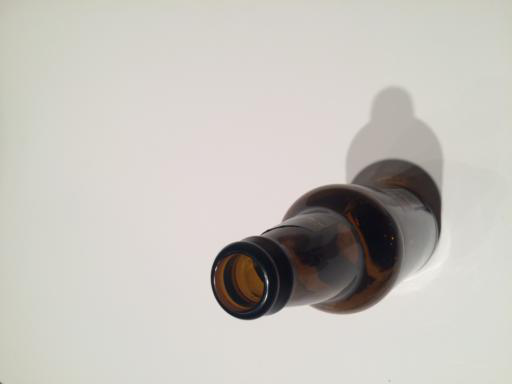

In [43]:
#Display a sample glass image
glass = list(data_dir.glob('glass/*'))
PIL.Image.open(str(glass[0]))

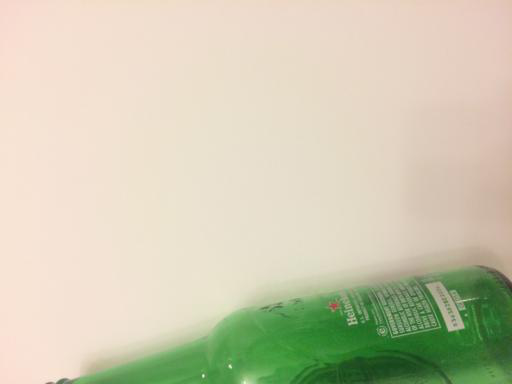

In [44]:
#Display another sample glass image
PIL.Image.open(str(glass[1]))

## Load Dataset

In [45]:
#Define some parameters for the loader:
batch_size = 32
img_height = 384
img_width = 512

In [46]:
# clear images folder, if already exist
folder = './images'
for filename in os.listdir(folder):
    file_path = os.path.join(folder, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

In [47]:
# define split method
def train_test_split_folders(data_dir):
    splitfolders.ratio(data_dir, output="images", seed=1337, ratio=(.8, 0.1,0.1))
    image_dir = 'images'

    #create training split  
    train_ds = tf.keras.utils.image_dataset_from_directory(
    image_dir + '/train',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

    #create validation split
    val_ds = tf.keras.utils.image_dataset_from_directory(
    image_dir + '/val',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

    #create validation split
    test_ds = tf.keras.utils.image_dataset_from_directory(
    image_dir + '/test',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = train_test_split_folders(data_dir=data_dir)

Copying files: 2527 files [00:01, 1572.50 files/s]


Found 2019 files belonging to 6 classes.
Found 251 files belonging to 6 classes.
Found 257 files belonging to 6 classes.


In [48]:
#Show names of the found classes
class_names = train_ds.class_names
print('The following claases were foung: '+ str(class_names))

The following claases were foung: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


## Standardize the data

In [49]:
# intializing rescaling layer to map onto data in the next step
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [50]:
# creating the normalized dataset
 
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in '[0, 1]'
print(np.min(first_image), np.max(first_image))

0.078431375 1.0


## Cache dataset

In [51]:
AUTOTUNE = tf.data.AUTOTUNE

#load data into cache to reduce i/o
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Define Model

In [52]:
num_classes = len(class_names)

model = tf.keras.Sequential(
    [
    tf.keras.layers.Rescaling(1./255),
    
    tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_classes)
    ]
)

In [53]:
# compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

## Train Model

In [54]:
# fit model
history = model.fit(
    train_ds,
    validation_data=val_ds, 
    epochs=8
)

Epoch 1/8
64/64 [==============================] - 10s 126ms/step - loss: 1.6527 - accuracy: 0.3006 - val_loss: 1.4983 - val_accuracy: 0.4343
Epoch 2/8
64/64 [==============================] - 8s 122ms/step - loss: 1.3836 - accuracy: 0.4537 - val_loss: 1.2526 - val_accuracy: 0.4861
Epoch 3/8
64/64 [==============================] - 8s 123ms/step - loss: 1.1724 - accuracy: 0.5542 - val_loss: 1.1417 - val_accuracy: 0.5857
Epoch 4/8
64/64 [==============================] - 8s 122ms/step - loss: 0.9948 - accuracy: 0.6181 - val_loss: 1.2894 - val_accuracy: 0.5697
Epoch 5/8
64/64 [==============================] - 8s 123ms/step - loss: 0.8573 - accuracy: 0.6781 - val_loss: 1.0251 - val_accuracy: 0.6016
Epoch 6/8
64/64 [==============================] - 8s 125ms/step - loss: 0.6893 - accuracy: 0.7548 - val_loss: 1.1695 - val_accuracy: 0.5857
Epoch 7/8
64/64 [==============================] - 8s 123ms/step - loss: 0.5834 - accuracy: 0.7935 - val_loss: 1.2969 - val_accuracy: 0.6175
Epoch 8/8
64

In [55]:
history = history.history

In [56]:
# summarize model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 384, 512, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 384, 512, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 192, 256, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 192, 256, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 96, 128, 64)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 96, 128, 32)      

## Export Model

In [57]:
# set current datetime
date = datetime.today().strftime("%Y-%m-%d_%H-%M")

In [58]:
# [Optional]
# save as tflite model, for later tflite deployment
# Convert the model.
convert_model = False

if convert_model:
      with open("./models/trash_classes.txt", "wb") as f:
            for cls in train_ds.class_names:
                  f.write(cls + "\n")
      
      converter = tf.lite.TFLiteConverter.from_keras_model(model)
      tflite_model = converter.convert()

      # Save the model.
      with open(f'./models/model_tflite_{date}.tflite', 'wb') as f:
            f.write(tflite_model)

In [59]:
# [Optional]
# save model
save_model = False
if save_model:      
      model.save(f'./models/model_{date}')

INFO:tensorflow:Assets written to: ./models/model_2023-02-24_14-49\assets


INFO:tensorflow:Assets written to: ./models/model_2023-02-24_14-49\assets


In [60]:
# [Optional]
#export training history
save = False

if save:
    np.save(f'./models/model_{date}_history.npy',history)

In [61]:
# [Optional]
#import previos training history
load = False
hist_dir = f'./models/model_{date}_history.npy'

if load:
    history=np.load(hist_dir,allow_pickle='TRUE').item()

## Show Model performance

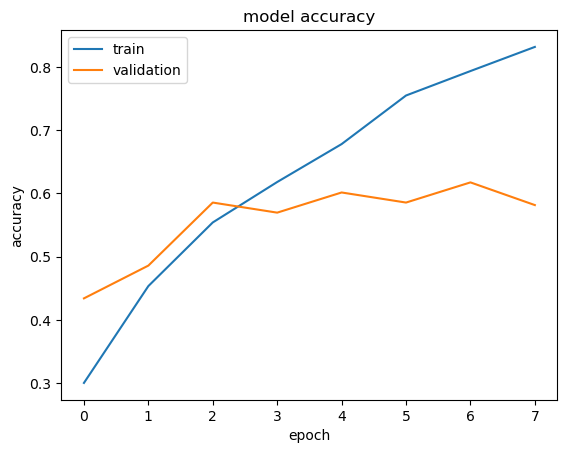

In [62]:
# plot accuracy

save_accuracy_img = False

def plot_history_acc(history):
    # summarize history for accuracy
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    if save_accuracy_img:
        plt.savefig('history_acc.png')
    
plot_history_acc(history)


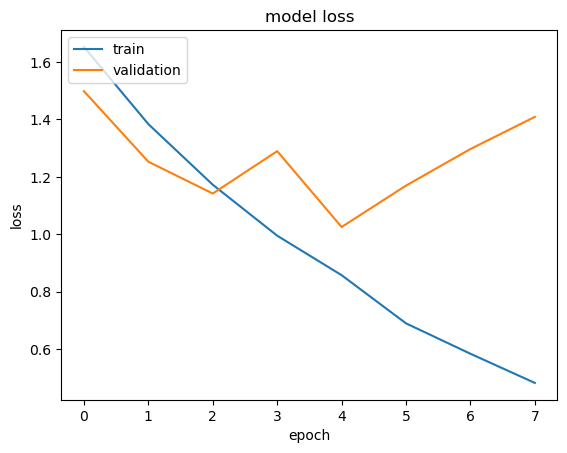

In [63]:
# plot model loss

save_loss_img = False

def plot_history_loss(history):
    # summarize history for loss
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    if save_loss_img:
        plt.savefig('history_loss.png')
    
plot_history_loss(history)

## Classify Images

1/1 [==============================] - 0s 18ms/step


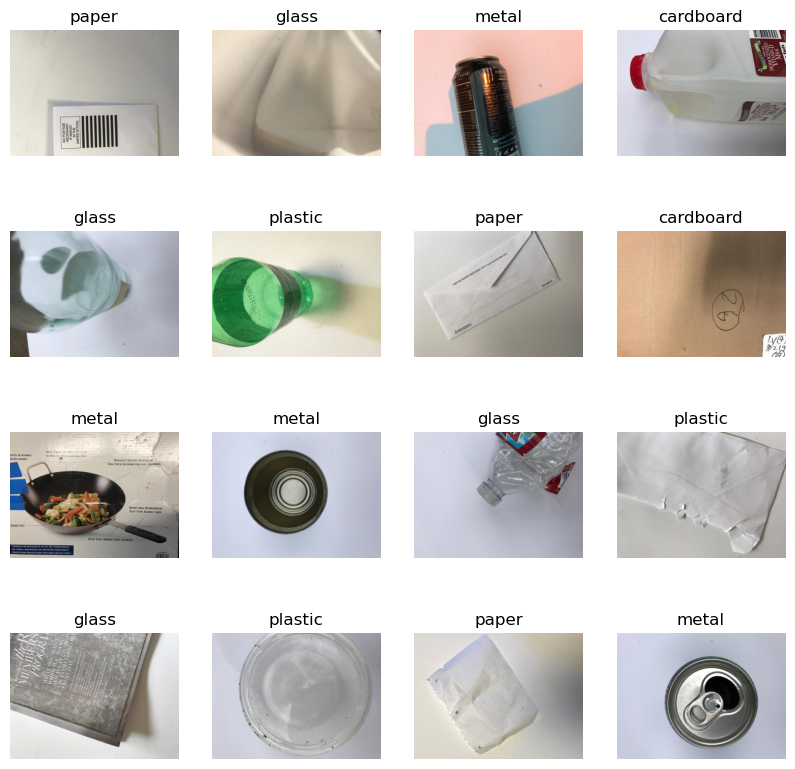

In [64]:
# show classifiaction of random test data

save_test_img = False

# read all test data
test_dir = "./images/test/"
test_files = glob.glob(test_dir + '/**/*', recursive = True)
random_test = random.sample(test_files,16) # select random sample

# plot predictions
plt.figure(figsize=(10, 10))
for i,image in enumerate(random_test):
    img = tf.keras.utils.load_img(image)
    img_array = tf.keras.utils.img_to_array(img) #
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    # predict for sample image
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(img)
    plt.title(class_names[np.argmax(score)])
    plt.axis("off")
    
    if save_test_img:
        plt.savefig('test_sample.png')